In [1]:
import tensorflow as tf
from keras.datasets import mnist

# import autokeras as ak
import pandas as pd

import torchvision.transforms as T
import torch.optim as optim
import os
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 8.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=2e9a95bd2858ed95961dee4e39adf7df22f13866cc2bb3cdd44f64140581ca91
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=3dbe7a10e8202382b32e0ebb1f0b5a1ec4b0de0f58d2de68e020bc7932f164d0
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
data = pd.read_csv('/kaggle/input/lacuna-solar-survey-challenge/Train.csv')
data.head()

,ID,img_origin,placement,boil_nbr,pan_nbr,polygon
0,ID00rw8,D,roof,0,2,"[(2087, 2179.0), (2181, 2191.0), (2171, 2223.0..."
1,ID014O6EC7,D,roof,0,1,"[(1327, 1574.0), (1595, 1308.0), (2169, 1744.0..."
2,ID020cu0z,D,openspace,0,1,"[(2215, 1372.0), (2400, 1422.0), (2316, 1716.0..."
3,ID024YTBkLvRpQahT,D,roof,0,1,"[(1574, 526.0), (1698, 366.0), (1810, 422.0), ..."
4,ID024YTBkLvRpQahT,D,roof,0,2,"[(1402, 782.0), (1814, 854.0), (1726, 1074.0),..."


In [4]:
data1 = pd.DataFrame(data.groupby(['ID']).agg({
    'boil_nbr': 'sum',      # Sum for 'Value1'
    'pan_nbr': 'sum'      # Mean for 'Value2'
})).reset_index()

In [5]:
left = [20,21,27,28,31,41,48,58,61,74,85,158,163,178,197,203,239,255,266,286,296,316,317,342,356,370,382,385,422,466,474,484,492,517,562,576,639,660,729,738,764,847,850,897,898,914,959,964,1007,1041,1087,1104,1163,1174,1180,1229,1235,1240,1246,1255,1275,1293,1321,1325,1350,1371,1396,1409,1414,1420,1457,1460,1493,1496,1527,1565,1592,1626,1627,1643,1659,1670,1697,1744,1748,1753,1756,1758,1765,1776,1783,1857,1881,1888,1906,1914,1917,1921,1932,1949,1960,1975,1978,1994,1999,2008]
right = [36,74,99,174,181,190,246,263,268,292,349,421,428,443,450,496,552,597,617,656,657,690,706,709,721,816,833,860,874,882,883,884,954,960,963,964,981,1001,1017,1093,1097,1122,1128,1143,1149,1171,1221,1252,1282,1292,1297,1306,1316,1323,1363,1398,1424,1498,1504,1513,1586,1637,1649,1675,1710,1755,1788,1808,1830,1848,1851,1870, 1895,1924]
drop = [43,60,65,91,152,180,272,330,343,347,399,403,416,430,480,483,491,582,606,623,667,688,740,742,815,848,855,890,891,899,945,982,1008,1042,1054,1071,1085,1095,1117,1133,1136,1165,1197,1344,1431,1500,1540,1542,1770]

In [6]:
right1 = [data1['ID'][i] for i in right]
left1 = [data1['ID'][i] for i in left]
drop1 = [data1['ID'][i] for i in drop]

In [7]:
# right1

In [8]:
train = data1.iloc[:1800,:]
val = data1.iloc[1800:2000,:]

In [9]:
idx1 = []
idx2 = []

In [10]:
for i in data.index:
    for j in train.index:
        if data['ID'][i] == train['ID'][j]:
            idx1.append(i)

for i in data.index:
    for j in val.index:
        if data['ID'][i] == val['ID'][j]:
            idx2.append(i)

In [11]:
train = data.iloc[idx1,:].reset_index(drop=True)
val = data.iloc[idx2,:].reset_index(drop=True)

In [12]:
train

,ID,img_origin,placement,boil_nbr,pan_nbr,polygon
0,ID00rw8,D,roof,0,2,"[(2087, 2179.0), (2181, 2191.0), (2171, 2223.0..."
1,ID014O6EC7,D,roof,0,1,"[(1327, 1574.0), (1595, 1308.0), (2169, 1744.0..."
2,ID020cu0z,D,openspace,0,1,"[(2215, 1372.0), (2400, 1422.0), (2316, 1716.0..."
3,ID024YTBkLvRpQahT,D,roof,0,1,"[(1574, 526.0), (1698, 366.0), (1810, 422.0), ..."
4,ID024YTBkLvRpQahT,D,roof,0,2,"[(1402, 782.0), (1814, 854.0), (1726, 1074.0),..."
...,...,...,...,...,...,...
3665,IDWrAIulSIORr5UTk,D,openspace,0,1,"[(1943, 1656.0), (2103, 1586.0), (2257, 1869.0..."
3666,IDWs6I2kZKwkc,D,roof,0,1,"[(1323, 1165.0), (1386, 979.0), (1642, 1029.0)..."
3667,IDWt4SNDgB,D,roof,0,1,"[(2035, 1308.0), (2289, 1354.0), (2317, 1540.0..."
3668,IDWtfE4NSbL7G,D,roof,0,1,"[(2310, 1460.0), (2591, 1466.0), (2582, 1914.0..."


In [13]:
def preprocess_polygon(s):
    ans = []
    lst1 = s.strip('[').strip(']').split('),')
    for s1 in lst1:
        # print(s1)
        s2 = []
        for j in s1.strip(' ').strip(')')[1:].split(','):
            if j == '6707z2':
                s2.append(6707.2)
            else:
                s2.append(float(j) )
        ans.append(tuple(s2))

    return ans

In [14]:
def get_vertex(id,data):
    # print(data.head())
    # print(id)
    vertex = []
    for i in data.index:
        # print(data['ID'].iloc[i])
        if data['ID'].iloc[i] == id:
            if data['boil_nbr'].iloc[i] != 0:
                vertex.append([preprocess_polygon(data['polygon'].iloc[i]),1])
            else:
                vertex.append([preprocess_polygon(data['polygon'].iloc[i]),2])
    # print(vertex)
    return vertex

In [15]:
def polygon_to_segmentation_mask(polygon, image):
    poly = polygon[0]
    val = polygon[1]
    # print(val)
    poly = np.array([poly],dtype=np.int32)
    cv2.fillPoly(image, poly, val)
    return image

In [16]:
class SupervisedDataset(Dataset):
    def __init__(self,data_path, dataframe, transforms):
        self.root_path = data_path
        self.transforms = transforms
        self.data = dataframe
        self.data1 = pd.DataFrame(self.data.groupby(['ID']).agg({
                    'boil_nbr': 'sum',      # Sum for 'Value1'
                    'pan_nbr': 'sum'      # Mean for 'Value2'
                })).reset_index()


        self.images = []
        self.targets = []
        self.vertex = []
        self.id = []

        for idx in self.data1.index:
            if self.data1['ID'][idx] not in ['IDmfKSa','IDa5zIYY2ZvtkGpp'] and self.data1['ID'][idx] not in drop1:
                self.images.append(os.path.join(self.root_path, self.data1['ID'].iloc[idx] + '.jpg'))
                self.vertex.append(get_vertex(self.data1['ID'].iloc[idx],self.data))
                self.id.append(self.data1['ID'].iloc[idx])

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert("RGB")
        size = img.size
        img = self.transforms(img)
        vertices = self.vertex[idx]
        # if vertices == []:
        # print(vertices)
        # print(vertices)
        mask = np.zeros((img.shape[1],img.shape[2]),dtype = np.int32)
        id1 = self.id[idx]
        # print(id1)
        for vertex in vertices:
            # print(vertex[0])
            lst2 = []
            lst1 = []
            for i in range(len(vertex[0])):
                # print(vertex[0][i])
                v1 = list(vertex[0][i])
                v1[0] = (v1[0]*512)/size[0]
                v1[1] = (v1[1]*512)/size[1]
                if id1 in left1:
                    v1[0] += 64
                    v1[1] += 64
                elif id1 in right1:
                    v1[0] -= 83
                    v1[1] -= 83
                lst2.append((v1[0],v1[1]))
            # print(lst2)
            lst1.append(lst2)
            lst1.append(vertex[1])
            # print(lst1)
            mask = polygon_to_segmentation_mask(lst1, mask)
        return img, mask.astype(int)

In [17]:
transforms = T.Compose([
    T.Resize((512,512)),  # Resize to a fixed size
    T.ToTensor(),          # Convert to PyTorch tensor
])
data_path = '/kaggle/input/lacuna-solar-survey-challenge/images'
train_data = SupervisedDataset(data_path,train, transforms)
val_data = SupervisedDataset(data_path,val, transforms)

In [18]:
val

,ID,img_origin,placement,boil_nbr,pan_nbr,polygon
0,IDWuHfhuMzZ,D,roof,0,1,"[(2964, 1764.0), (2924, 1916.0), (2668, 1916.0..."
1,IDWuaaDji1,S,S-unknown,0,3,"[(299, 325.0), (349, 313.0), (357, 336.0), (29..."
2,IDWuaaDji1,S,S-unknown,1,0,"[(316, 346.0), (338, 343.0), (325, 392.0), (29..."
3,IDWuf2fp,D,roof,0,1,"[(2493, 3575.0), (2555, 3578.0), (2549, 3634.0..."
4,IDWuf2fp,D,roof,0,1,"[(1042, 124.0), (1083, 115.0), (1058, 158.0), ..."
...,...,...,...,...,...,...
371,IDaDLQId,S,S-unknown,1,0,"[(245, 81.0), (259, 81.0), (261, 126.0), (233,..."
372,IDaDLQId,S,S-unknown,1,0,"[(236, 365.0), (257, 359.0), (261, 412.0), (23..."
373,IDaF0yrYKLEiu,D,roof,0,1,"[(1788, 1694.0), (2057, 1551.0), (2321, 1876.0..."
374,IDaFand,D,roof,0,2,"[(1797, 1661.0), (2023, 1625.0), (2252, 1659.0..."


In [19]:
# i = 0
# for image,labels in val_data:
#     if i == 31:
#         plt.imshow(labels)
#         break
#     i+=1

In [20]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.optim import Adam


model = smp.Unet(
    encoder_name="resnet34",        # Backbone architecture (e.g., ResNet34)
    encoder_weights="imagenet",     # Use ImageNet pre-trained weights for the backbone
    in_channels=3,                  # Input channels (e.g., RGB image with 3 channels)
    classes=3                       # Number of output classes (e.g., binary segmentation)
)


optimizer = Adam(model.parameters(), lr = 0.001)

criterion = nn.CrossEntropyLoss()

epochs = 10

train_loader = DataLoader(train_data, batch_size = 4, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 4, shuffle = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 258MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [21]:
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    for image,label in train_loader:
        image,label = image.to(device),label.long().to(device)
        # print(label)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output,label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for image, label in val_loader:
            image,label = image.to(device),label.long().to(device)
            output = model(image)
            loss = criterion(output,label)
            val_loss += loss.item()

    print(f'epoch : {epoch}  train_loss: {train_loss}  val_loss: {val_loss}')

epoch : 0  train_loss: 40.556370068341494  val_loss: 2.6496986970305443
epoch : 1  train_loss: 23.7966440487653  val_loss: 2.0370587008073926
epoch : 2  train_loss: 22.188833095133305  val_loss: 2.3523768354207277
epoch : 3  train_loss: 20.8597953915596  val_loss: 2.0279584703966975
epoch : 4  train_loss: 20.173454537056386  val_loss: 1.9538278756663203
epoch : 5  train_loss: 19.563451938331127  val_loss: 2.049930140376091
epoch : 6  train_loss: 18.601105974055827  val_loss: 2.0367300314828753
epoch : 7  train_loss: 18.71940074628219  val_loss: 1.9092249516397715
epoch : 8  train_loss: 17.865813428070396  val_loss: 1.874814035370946
epoch : 9  train_loss: 17.302577591501176  val_loss: 1.8288977895863354


In [22]:
optimizer = Adam(model.parameters(), lr = 0.00005)
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    for image,label in train_loader:
        image,label = image.to(device),label.long().to(device)
        # print(label)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output,label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        for image, label in val_loader:
            image,label = image.to(device),label.long().to(device)
            output = model(image)
            loss = criterion(output,label)
            val_loss += loss.item()

    print(f'epoch : {epoch}  train_loss: {train_loss}  val_loss: {val_loss}')

epoch : 0  train_loss: 15.558011451736093  val_loss: 1.7899264646694064
epoch : 1  train_loss: 15.01952062593773  val_loss: 1.7781245661899447
epoch : 2  train_loss: 14.126614519860595  val_loss: 1.7357524302788079
epoch : 3  train_loss: 13.805710280314088  val_loss: 1.7601893991231918
epoch : 4  train_loss: 13.249082889407873  val_loss: 1.7726153004914522
epoch : 5  train_loss: 12.661815171130002  val_loss: 1.8031168919987977
epoch : 6  train_loss: 12.334953239187598  val_loss: 1.7760045202448964
epoch : 7  train_loss: 11.81591532425955  val_loss: 1.7636488950811327
epoch : 8  train_loss: 11.414652923122048  val_loss: 1.7907784297131002
epoch : 9  train_loss: 11.158543318510056  val_loss: 1.7644456806592643


In [23]:
torch.save(model.state_dict(), "model_50.pth")

In [24]:
lst1 = os.listdir('/kaggle/input/lacuna-solar-survey-challenge/images')

lst2 = np.random.choice(lst1, size=10)

In [25]:
lst2

array(['IDVA7EXpfZfFA.jpg', 'IDBu1JtoNpk.jpg', 'ID39iR1agmucAFZL.jpg',
       'IDzdqMimk7v.jpg', 'IDmJmyjn7b.jpg', 'IDIgkWDaqwXXozOI.jpg',
       'ID97jEo.jpg', 'IDOtmngoVnZx87fx.jpg', 'IDpUdTlDNBsyD.jpg',
       'IDOfqpGoqW2nW.jpg'], dtype='<U21')

In [26]:
i =0
transforms = T.Compose([
    T.Resize((512,512)),  # Resize to a fixed size
    T.ToTensor(),          # Convert to PyTorch tensor
])

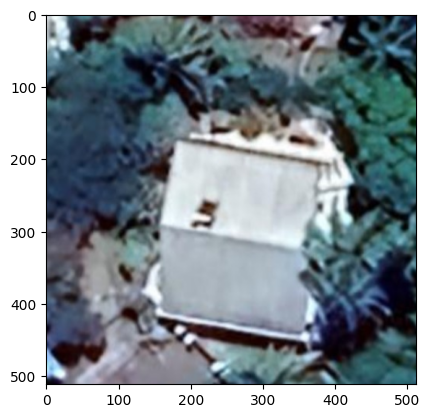

In [27]:
img_path = os.path.join('/kaggle/input/lacuna-solar-survey-challenge/images', lst2[i])
img = Image.open(img_path).convert("RGB")
img = transforms(img)
plt.imshow(img.permute(1,2,0))
i+=1
    

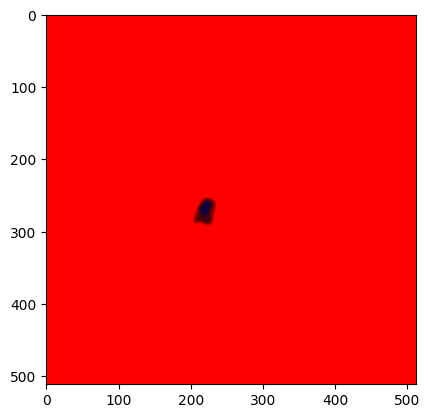

In [28]:
with torch.no_grad():
    mask = model(img.unsqueeze(0).to(device))

plt.imshow(mask[0].permute(1,2,0).cpu().numpy())